In [1]:
# USE THESE TO INSTALL

"""
## install finrl library
!pip install wrds
!pip install swig
!pip install finrl==0.3.5

## instal elegantrl
# !pip install elegantrl==0.3.3

!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
"""

'\n## install finrl library\n!pip install wrds\n!pip install swig\n!pip install finrl==0.3.5\n\n## instal elegantrl\n# !pip install elegantrl==0.3.3\n\n!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git\n'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent

from stable_baselines3.common.logger import configure

from finrl.plot import backtest_stats, backtest_plot, get_baseline

import sys
sys.path.append("../FinRL")



C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



In [4]:
config_tickers.DOW_30_TICKER

['AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'KO',
 'JPM',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'CRM',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'DOW']

In [5]:
tickers_list = ['MSFT', 'AAPL', 'CAT', 'CSCO', 'NKE']

df = YahooDownloader(start_date = '2012-01-01',
                     end_date = '2023-10-31',
                     ticker_list = tickers_list).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (14880, 8)


In [6]:
print(tickers_list)

['MSFT', 'AAPL', 'CAT', 'CSCO', 'NKE']


In [7]:
df.shape

(14880, 8)

In [8]:
# df.sort_values(['date','tic'],ignore_index=True).head()
df.sort_values(['date'],ignore_index=True)

,date,open,high,low,close,volume,tic,day
0,2012-01-03,14.621429,14.732143,14.607143,12.449689,302220800,AAPL,1
1,2012-01-03,92.769997,95.110001,92.769997,67.953003,8177000,CAT,1
2,2012-01-03,18.549999,18.860001,18.480000,12.924058,41236600,CSCO,1
3,2012-01-03,26.549999,26.959999,26.389999,21.278032,64731500,MSFT,1
4,2012-01-03,24.342501,24.497499,24.174999,21.074886,10944400,NKE,1
...,...,...,...,...,...,...,...,...
14875,2023-10-30,333.410004,339.450012,331.829987,336.626770,22828100,MSFT,0
14876,2023-10-30,169.020004,171.169998,168.869995,170.065933,51131000,AAPL,0
14877,2023-10-30,240.940002,243.600006,239.179993,242.160004,4478300,CAT,0
14878,2023-10-30,51.349998,51.639999,51.090000,51.171814,13322400,CSCO,0


In [9]:
feature_engineer = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list = ['macd',
    'boll_ub',
    'boll_lb',
    'rsi_30',
    'cci_30',
    'dx_30',
    'close_30_sma',
    'close_60_sma'],
    use_vix=True,
    use_turbulence=True,
    user_defined_feature = False)

states_df = feature_engineer.preprocess_data(df)

Successfully added technical indicators


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (2975, 8)
Successfully added vix
Successfully added turbulence index


In [10]:
from itertools import product
dates = list(pd.date_range(states_df['date'].min(),states_df['date'].max()).astype(str))

preprocessed_df = pd.DataFrame(list(product(dates,tickers_list)),columns=["date","tic"])
preprocessed_df = preprocessed_df.merge(states_df,how="left",on=["date","tic"],)
preprocessed_df = preprocessed_df[preprocessed_df['date'].isin(states_df['date'])]
preprocessed_df = preprocessed_df.sort_values(['date','tic'])

preprocessed_df = preprocessed_df.fillna(0)



In [11]:
preprocessed_df.describe()

,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
count,14875.000000,14875.000000,14875.000000,14875.000000,1.487500e+04,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000
mean,87.925341,88.823777,87.011258,81.711926,5.318533e+07,2.024874,0.364079,85.793759,76.633687,53.993698,25.419957,24.035344,80.960192,80.175403,17.832192,5.082796
std,69.802263,70.572683,68.999996,69.519045,1.044569e+08,1.398985,1.978481,73.222779,65.009080,9.108032,112.768150,17.081371,68.799795,68.013646,6.851859,9.983662
min,13.856071,14.271429,13.753571,10.578132,5.857000e+05,0.000000,-9.607839,11.796429,10.061002,25.806161,-519.458107,0.002358,11.423214,11.510131,9.140000,0.000000
25%,35.806250,36.121250,35.495001,31.222950,6.484750e+06,1.000000,-0.265390,32.151753,29.122308,47.574028,-60.106072,10.040956,30.320554,29.099533,13.370000,1.100484
50%,58.730000,59.349998,58.250000,54.248795,1.986530e+07,2.000000,0.231522,56.488090,51.163763,53.864373,43.016073,21.417965,53.548150,53.097536,16.070000,2.442872
75%,123.434998,124.844997,121.505001,116.092136,4.488855e+07,3.000000,0.905560,123.432461,105.970707,59.981754,108.892142,35.287715,114.693447,114.526896,20.549999,5.185709
max,361.750000,366.779999,352.440002,358.003845,1.506120e+09,4.000000,13.481134,358.153223,327.322526,100.000000,666.478672,100.000000,338.987468,332.702074,82.690002,137.878037


In [12]:
train = data_split(preprocessed_df, '2012-01-01','2020-07-01')
test = data_split(preprocessed_df, '2020-07-01','2023-10-31')


In [13]:
train

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2012-01-03,AAPL,14.621429,14.732143,14.607143,12.449689,302220800.0,1.0,0.000000,12.577769,12.388519,100.000000,66.666667,100.000000,12.449689,12.449689,22.969999,0.000000
0,2012-01-03,CAT,92.769997,95.110001,92.769997,67.953003,8177000.0,1.0,0.000000,12.577769,12.388519,100.000000,66.666667,100.000000,67.953003,67.953003,22.969999,0.000000
0,2012-01-03,CSCO,18.549999,18.860001,18.480000,12.924058,41236600.0,1.0,0.000000,12.577769,12.388519,100.000000,66.666667,100.000000,12.924058,12.924058,22.969999,0.000000
0,2012-01-03,MSFT,26.549999,26.959999,26.389999,21.278032,64731500.0,1.0,0.000000,12.577769,12.388519,100.000000,66.666667,100.000000,21.278032,21.278032,22.969999,0.000000
0,2012-01-03,NKE,24.342501,24.497499,24.174999,21.074886,10944400.0,1.0,0.000000,12.577769,12.388519,100.000000,66.666667,100.000000,21.074886,21.074886,22.969999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,2020-06-30,AAPL,90.019997,91.495003,90.000000,89.301918,140223200.0,1.0,3.047960,91.772521,78.668551,63.073211,107.459165,28.116947,82.797496,76.632956,30.430000,3.059442
2136,2020-06-30,CAT,124.010002,127.059998,124.010002,117.040123,2778800.0,1.0,1.278037,126.300945,109.645476,53.144613,22.193996,8.424421,115.004339,109.757677,30.430000,3.059442
2136,2020-06-30,CSCO,46.150002,47.009998,46.099998,41.582504,21888800.0,1.0,0.264298,43.242783,39.032444,54.484005,47.393427,14.675050,41.006554,39.310504,30.430000,3.059442
2136,2020-06-30,MSFT,197.880005,204.399994,197.740005,197.193268,34310300.0,1.0,4.655629,199.382226,175.765622,60.679216,130.573076,29.201117,184.204036,176.992383,30.430000,3.059442


In [14]:
test

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.133011,110737200.0,2.0,2.988733,91.903733,79.491803,62.807149,107.505485,29.730532,83.213406,77.050533,28.620001,1.158807
0,2020-07-01,CAT,129.380005,129.399994,125.879997,116.633034,2807800.0,2.0,1.230241,126.273505,109.577619,52.865423,35.773248,14.457404,115.435491,109.861388,28.620001,1.158807
0,2020-07-01,CSCO,46.540001,46.720001,46.000000,41.065403,17129500.0,2.0,0.257263,43.176731,39.020039,53.160558,19.390174,13.380576,41.049646,39.379303,28.620001,1.158807
0,2020-07-01,MSFT,203.139999,206.350006,201.770004,198.346344,32061200.0,2.0,4.892477,200.627271,176.394547,61.184873,140.812867,33.015146,184.901043,177.636564,28.620001,1.158807
0,2020-07-01,NKE,98.500000,98.720001,97.110001,94.027046,5733800.0,2.0,0.604547,101.314969,90.103421,52.347817,-25.373668,10.077761,95.259395,89.802713,28.620001,1.158807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,2023-10-27,AAPL,166.910004,168.960007,166.830002,167.998672,58499100.0,4.0,-1.928420,182.400054,167.304235,41.106551,-159.559754,44.522007,174.545713,176.867997,21.270000,3.086771
837,2023-10-27,CAT,243.050003,243.919998,237.860001,238.559998,3229900.0,4.0,-7.770853,282.027943,237.547927,37.176350,-185.800870,57.104296,264.389057,271.011240,21.270000,3.086771
837,2023-10-27,CSCO,51.639999,52.150002,51.400002,51.161896,13333900.0,4.0,-0.579820,54.460450,51.251966,42.589498,-186.003447,38.086601,53.016064,53.783766,21.270000,3.086771
837,2023-10-27,MSFT,330.429993,336.720001,328.399994,329.141968,29856500.0,4.0,1.856144,339.244674,315.557319,51.322881,66.282036,1.795524,324.281493,325.163122,21.270000,3.086771


In [15]:
stock_size = len(tickers_list)
state_space = 1 + 2*stock_size + len(['macd',
    'boll_ub',
    'boll_lb',
    'rsi_30',
    'cci_30',
    'dx_30',
    'close_30_sma',
    'close_60_sma'])*stock_size

# 8 indictor/price features PER stock (there's 5 here)
# Plus, the raw price data is captured again as 2 extra features per stock (typically Open and Close price).
# So + 2N state variables
# Hence 8*5 (indicators) + 2*5 (raw price) + 1 (offset variable)

stock_size, state_space

(5, 51)

In [16]:
training_environment, initial_observations = StockTradingEnv(df = train, hmax= 100,
    initial_amount= 1000000, # STARTING AMOUNT HERE
    num_stock_shares= [0] * stock_size,
    buy_cost_pct= [.1/100] * stock_size, # Transaction fee percent of buys per stock
    sell_cost_pct= [.1/100] * stock_size,
    state_space= state_space,
    stock_dim= stock_size, # Stock dimensions
    tech_indicator_list= ['macd',
    'boll_ub',
    'boll_lb',
    'rsi_30',
    'cci_30',
    'dx_30',
    'close_30_sma',
    'close_60_sma'],
    action_space= stock_size, 
    reward_scaling= 1e-4).get_sb_env() 
# creates a vectorized environment compatible with Stable Baselines algorithms
# uses DummyVecEnv from Stable Baselines to create a vectorized wrapper of the trading env
# wraps the env in a Vectorized environment that handles all the multiprocessing - steps, resets etc.
# It calls reset() on the vectorized env to get the initial observations
"""
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.
"""


"\nThe training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.\n\nOur market environment, based on OpenAI Gym, simulates stock markets with historical market data.\n"

## Environment for Training



### Agent 1: A2C


In [23]:
# Automatically build models from list of model names
agent = DRLAgent(training_environment)
models=[]
def log_model(model_name):
    print(model_name)
    model = agent.get_model(f"{model_name}")
    model.set_logger(configure(RESULTS_DIR + f'/{model_name}', ["stdout", "csv", "tensorboard"]))
    models.append((model_name, model))

model_names=['a2c'
            ,'ddpg'
            # ,'ppo'
            # ,'sac'
            ]
for model_name in model_names:
    log_model(model_name)
print(models)



a2c
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c
ddpg
{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg
[('a2c', <stable_baselines3.a2c.a2c.A2C object at 0x00000277B99490C0>), ('ddpg', <stable_baselines3.ddpg.ddpg.DDPG object at 0x00000277B99490F0>)]


In [26]:
a2c_params = {
    "n_steps": 5,
    "ent_coef": 0.01,
    "learning_rate": 7e-4,
    "gamma": 0.99,
    "gae_lambda": 0.95
}

agent = DRLAgent(training_environment)
a2c_model = agent.get_model("a2c", model_kwargs=a2c_params)
tmp_path = RESULTS_DIR + '/a2c'
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
a2c_model.set_logger(new_logger_a2c)

# A2C HYPERPARAMS MOST IMPORTANT
# learning_rate: The learning rate determines how quickly the model learns from new experiences. This is one of the most important to get right. Too small and it will learn slowly. Too large and it may have issues converging.
# n_steps: The number of steps collected before each update. More steps allows more efficient batch updates but delays learning from recent experiences. Finding a good balance is important.
# gamma: The discount factor determines how much the agent values future rewards. Higher values make it value long-term rewards more.
# gae_lambda: The GAE lambda controls the bias-variance tradeoff for estimating returns. Values closer to 1 have lower variance but higher bias.
# ent_coef: The entropy coefficient controls how much the agent is encouraged to explore randomly. Higher values result in more random actions.
# max_grad_norm: Gradient clipping limit to improve stability. You generally don't need to tune this much.


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007, 'gamma': 0.99, 'gae_lambda': 0.95}
Using cpu device
Logging to results/a2c


In [27]:
trained_a2c = DRLAgent(training_environment).train_model(model=a2c_model,
                             tb_log_name='a2c',
                             total_timesteps=50000) 

--------------------------------------
| time/                 |            |
|    fps                | 370        |
|    iterations         | 100        |
|    time_elapsed       | 1          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -7.28      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | 0.628      |
|    reward             | 0.10003708 |
|    std                | 1.04       |
|    value_loss         | 0.0438     |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 341        |
|    iterations         | 200        |
|    time_elapsed       | 2          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -7.31      |
|    explained_variance | 1.19e-07   |
|    learning_rate      |

In [ ]:

# DDPG HYPERPARAMS MOST IMPORTANT
# learning_rate: Determines how quickly the model learns from new data. Too low may learn slowly, too high can destabilize training.
# buffer_size: The size of the replay buffer holding experiences. Larger buffers allow longer term learning but cost memory.
# batch_size: The size of sampled batch from the replay buffer for learning updates. Too small may underutilize GPU/CPU resources.
# tau: Controls weighting between older and newer Q-network weights during update. Controls stability vs plasticity.
# train_freq: How frequently the model trains. Balance between learning from more data vs more frequent updates.
# gradient_steps: Number of gradient steps during each training update. More may increase stability.


In [ ]:
agent = DRLAgent(env = training_environment)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

# set up logger
new_logger_ppo = configure(RESULTS_DIR + '/ppo', ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/a2c


In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000)

-----------------------------------------
| time/                   |             |
|    fps                  | 556         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.008732445 |
|    clip_fraction        | 0.0947      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.1        |
|    explained_variance   | 0.293       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.2        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00872    |
|    reward               | -8.01567    |
|    std                  | 1           |
|    value_loss           | 33          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 519          |
|    iterations           | 2  

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [28]:
data_risk_indicator = preprocessed_df[(preprocessed_df.date<'2020-07-01') & (preprocessed_df.date>='2012-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [29]:
insample_risk_indicator.vix.describe()

count    2137.000000
mean       16.258573
std         6.805276
min         9.140000
25%        12.740000
50%        14.530000
75%        17.500000
max        82.690002
Name: vix, dtype: float64

In [30]:
insample_risk_indicator.vix.quantile(0.996)

61.626479248046884

In [31]:
insample_risk_indicator.turbulence.describe()

count    2137.000000
mean        5.070206
std        10.291582
min         0.000000
25%         0.998157
50%         2.360579
75%         5.081053
max       134.426655
Name: turbulence, dtype: float64

In [32]:
insample_risk_indicator.turbulence.quantile(0.996)

89.72780414401996

In [37]:
# TESTING OVER HERE
trading_environment = StockTradingEnv(df = test, turbulence_threshold = 70,risk_indicator_col='vix', hmax= 100,
    initial_amount= 1000000, # STARTING AMOUNT HERE
    num_stock_shares= [0] * stock_size,
    buy_cost_pct= [.1/100] * stock_size, # Transaction fee percent of buys per stock
    sell_cost_pct= [.1/100] * stock_size,
    state_space= state_space,
    stock_dim= stock_size, # Stock dimensions
    tech_indicator_list= ['macd',
    'boll_ub',
    'boll_lb',
    'rsi_30',
    'cci_30',
    'dx_30',
    'close_30_sma',
    'close_60_sma'],
    action_space= stock_size, 
    reward_scaling= 1e-4)
env_trade, obs_trade = trading_environment.get_sb_env()

In [68]:
# trained_model_ddpg = trained_ddpg
# df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
#     model=trained_model_ddpg,
#     environment = trading_environment)


testing_a2c_model = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=testing_a2c_model,
    environment = trading_environment)

# trained_model_ppo = trained_ppo
# df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
#     model=trained_model_ppo,
#     environment = trading_environment)



hit end!


In [69]:
train
a2c_params =  testing_a2c_model.get_parameters()
a2c_params['policy']
a2c_params['policy.optimizer']    
df_account_value_a2c
df_actions_a2c
print()

In [70]:

perf_stats_all = pd.DataFrame(backtest_stats(account_value=df_account_value_a2c))
# perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+datetime.datetime.now().strftime('%Y%m%d-%Hh%M')+'.csv')

Annual return          0.179689
Cumulative returns     0.732431
Annual volatility      0.265851
Sharpe ratio           0.754914
Calmar ratio           0.602539
Stability              0.557314
Max drawdown          -0.298220
Omega ratio            1.140572
Sortino ratio          1.127433
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.044634
Daily value at risk   -0.032698
dtype: float64


C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [71]:
baseline_df = get_baseline(
        ticker="^DJI",
        start = df_account_value_a2c.loc[0,'date'],
        end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (837, 8)
Annual return          0.075612
Cumulative returns     0.273920
Annual volatility      0.154568
Sharpe ratio           0.549480
Calmar ratio           0.344619
Stability              0.251243
Max drawdown          -0.219408
Omega ratio            1.096731
Sortino ratio          0.782356
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.001898
Daily value at risk   -0.019137
dtype: float64



C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [ ]:
df_account_value_a2c['date']

0      2020-07-01
1      2020-07-02
2      2020-07-06
3      2020-07-07
4      2020-07-08
          ...    
833    2023-10-23
834    2023-10-24
835    2023-10-25
836    2023-10-26
837    2023-10-27
Name: date, Length: 838, dtype: object

In [ ]:
df_account_value_a2c.loc[0,'date']

'2020-07-01'

In [ ]:
df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date']

'2023-10-27'

In [ ]:
import pyfolio
import pandas as pd
from pandas_datareader import data as pdr

def BackTestPlot(strategy_returns, 
                 baseline_start, 
                 baseline_end,
                 baseline_ticker='^DJI'):

    # Get benchmark returns
    benchmark_returns = pdr.get_data_yahoo(
        baseline_ticker, 
        start=baseline_start, 
        end=baseline_end)['Close'].pct_change()

    # Ensure datetime indexes
    strategy_returns.index = pd.to_datetime(strategy_returns.index)
    benchmark_returns.index = pd.to_datetime(benchmark_returns.index)

    # Plot tear sheet
    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_returns_tear_sheet(
            returns=strategy_returns,
            benchmark_rets=benchmark_returns,
            set_context=False
        )


<a id='6.2'></a>
## 7.2 BackTestPlot

In [ ]:
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

backtest_plot(df_account_value_a2c,
             baseline_ticker = '^NDX',
             baseline_start = df_account_value_a2c.loc[0,'date'],
             baseline_end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (837, 8)



C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2020-07-01
End date,2023-10-27
Total months,39
,Backtest
Annual return,11.3%
Cumulative returns,42.7%
Annual volatility,25.4%
Sharpe ratio,0.55
Calmar ratio,0.28
Stability,0.15
Max drawdown,-40.8%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'

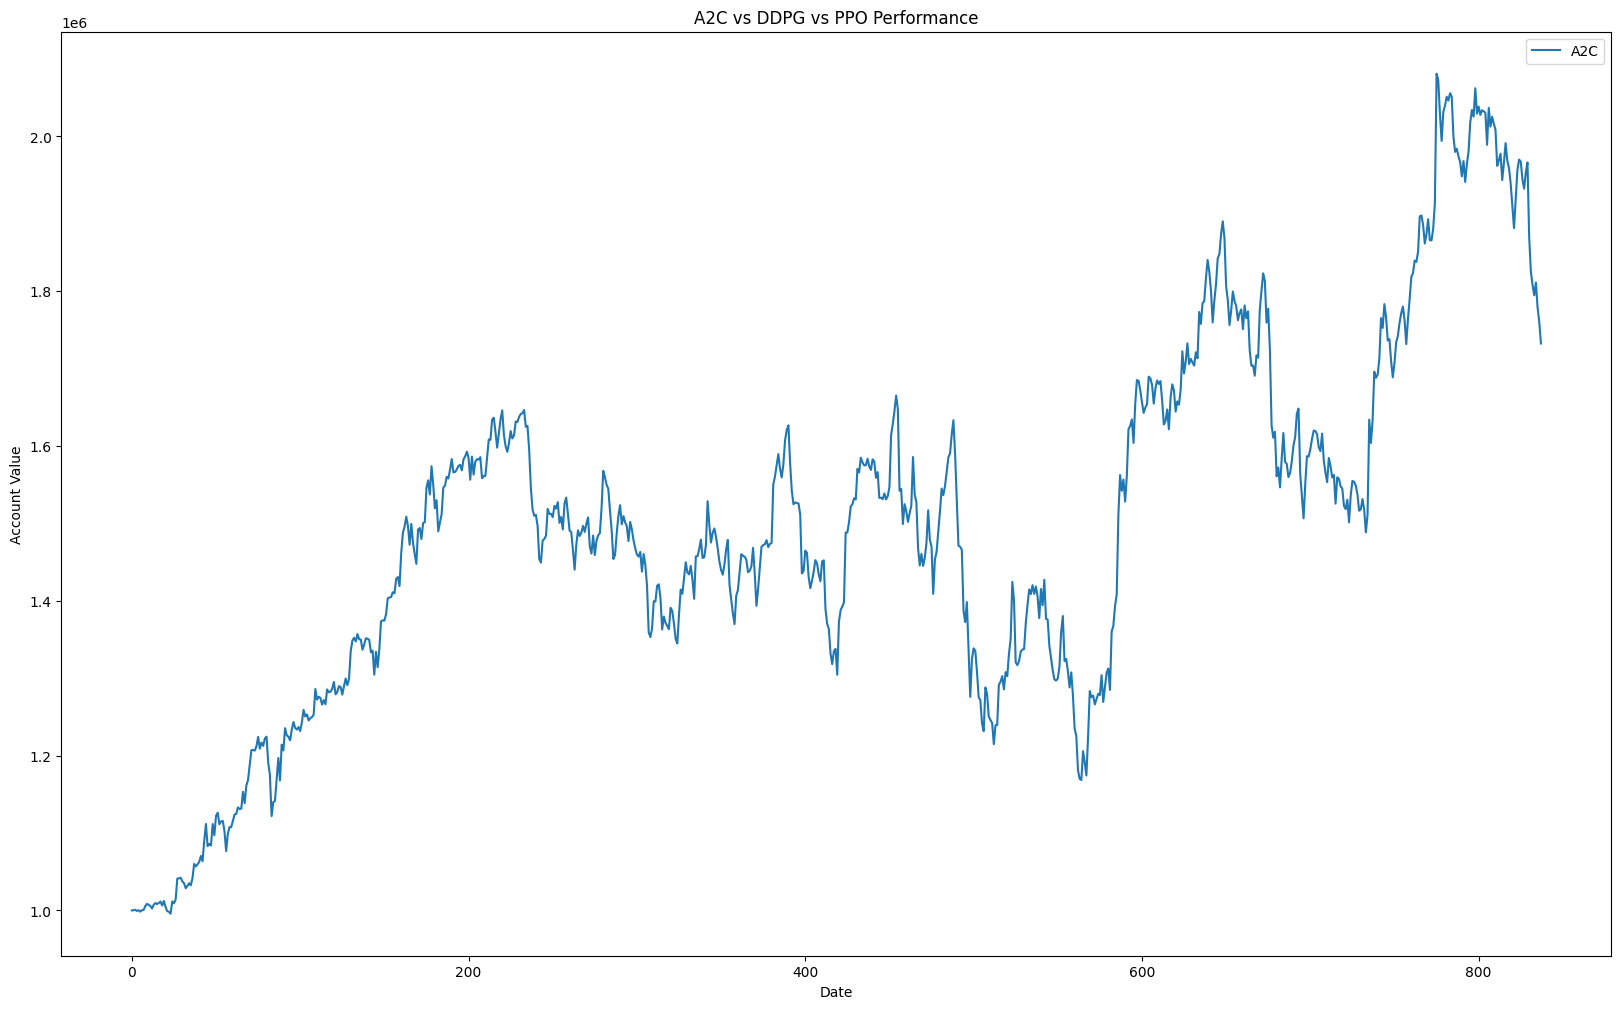

In [50]:
df_account_value_a2c['account_value']
# %matplotlib inline
# df_account_value_ddpg['account_value']

plt.figure(figsize=(20, 12))
plt.plot(df_account_value_a2c.index, df_account_value_a2c['account_value'], label='A2C')
# plt.plot(df_account_value_ddpg.index, df_account_value_ddpg['account_value'], label='DDPG')
# plt.plot(df_account_value_ppo.index, df_account_value_ppo['account_value'], label='PPO')


plt.title('A2C vs DDPG vs PPO Performance')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.legend()
plt.show()


In [ ]:
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
df_ndx_ = get_baseline(
        ticker="^NDX", 
        start = '2020-07-01',
        end = '2023-10-31')
stats = backtest_stats(df_ndx_, value_col_name = 'close')
df_ndx = pd.DataFrame()
df_ndx['date'] = df_account_value_a2c['date']
df_ndx['account_value'] = df_ndx_['close'] / df_ndx_['close'][0] * env_kwargs["initial_amount"]


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (839, 8)
Annual return          0.105063
Cumulative returns     0.394607
Annual volatility      0.245297
Sharpe ratio           0.530538
Calmar ratio           0.295428
Stability              0.044324
Max drawdown          -0.355631
Omega ratio            1.092124
Sortino ratio          0.750085
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.952510
Daily value at risk   -0.030388
dtype: float64



C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
